In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import scipy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
import xgboost as xgb
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
phone_accel_df = pd.DataFrame()
filenames = os.listdir('wisdm-dataset/arff_files/phone/accel')
filenames.pop(0)
for file in filenames:
    path = "wisdm-dataset/arff_files/phone/accel/" + file
    data = arff.loadarff(path)
    df = pd.DataFrame(data[0])
    print("for file at " + path + "shape is: " + str(df.shape))
    frames = [df, phone_accel_df]
    phone_accel_df = pd.concat(frames, sort = False)
    
print(phone_accel_df.shape)
    
phone_accel_old_column_names = phone_accel_df.columns

phone_accel_new_column_names = []
for name in phone_accel_old_column_names:
    phone_accel_new_column_names.append(name.replace('"', ''))
    
replacement_dict = dict(zip(phone_accel_old_column_names, phone_accel_new_column_names))
phone_accel_df = phone_accel_df.rename(columns = replacement_dict)
#phone_accel_df.head()

labelencoder = LabelEncoder()
phone_accel_df['ACTIVITY'] = labelencoder.fit_transform(phone_accel_df['ACTIVITY'])
#phone_accel_df.head()

phone_accel_df.pop('class')

phone_accel_df_shuffle = shuffle(phone_accel_df)

phone_accel_data = phone_accel_df_shuffle.to_numpy()

X_phone_accel = phone_accel_data[:,1:]
Y_phone_accel = phone_accel_data[:,0]
print(X_phone_accel.shape)
print(Y_phone_accel.shape)

x_train, x_test, y_train, y_test = train_test_split(X_phone_accel, Y_phone_accel, test_size = 0.2)

for file at wisdm-dataset/arff_files/phone/accel/data_1600_accel_phone.arffshape is: (321, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1601_accel_phone.arffshape is: (407, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1602_accel_phone.arffshape is: (424, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1603_accel_phone.arffshape is: (409, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1604_accel_phone.arffshape is: (321, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1605_accel_phone.arffshape is: (406, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1606_accel_phone.arffshape is: (321, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1607_accel_phone.arffshape is: (383, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1608_accel_phone.arffshape is: (482, 93)
for file at wisdm-dataset/arff_files/phone/accel/data_1609_accel_phone.arffshape is: (306, 93)
for file at wisdm-dataset/arff_files/phone/accel/d

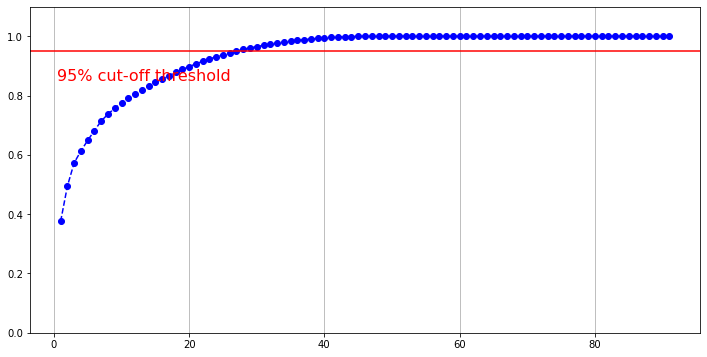

In [4]:
x_pca = StandardScaler().fit_transform(x_train)

pca = PCA().fit(x_pca)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 92, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize = 16)

ax.grid(axis='x')
plt.show()

In [5]:
pca = PCA(n_components = 28)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [6]:

space={ 'eta': hp.uniform("eta", 0.001, 0.5),
        'max_depth': hp.quniform("max_depth", 3, 30, 1),
        'gamma': hp.uniform ('gamma', 1,10),
        'reg_alpha' : hp.uniform('reg_alpha', 0,20),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.01,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 400, 50),
        'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
        'subsample': hp.uniform('subsample', 0.001, 1),
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.01, 1),
        'scale_pos_weight': hp.uniform('scale_pos_weaight', 0, 1),
    }


In [7]:
def objective(space):
    clf=xgb.XGBClassifier( eta = space['eta'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'], reg_lambda = space['reg_lambda'],
                    min_child_weight=int(space['min_child_weight']), colsample_bytree=int(space['colsample_bytree']), 
                    max_delta_step = space['max_delta_step'], subsample = space['subsample'],
                    colsample_bylevel = space['colsample_bylevel'], scale_pos_weight = space['scale_pos_weight'],
                    objective = 'multi:softmax')
    
    evaluation = [( x_train_pca, y_train), ( x_test_pca, y_test)]
    
    clf.fit(x_train_pca, y_train_pca,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test_pca)
    accuracy = accuracy_score(y_test_pca, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [8]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print(best_hyperparams)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\ASUS\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[13:03:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.5200433369447454                                                                                                     
[13:04:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core,

0.40303358613217766                                                                                                    
[13:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.5315276273022752                                                                                                     
[13:21:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a fals

SCORE:                                                                                                                 
0.6294691224268689                                                                                                     
[13:30:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.29967497291440953                                                                                                    
[13:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.

SCORE:                                                                                                                 
0.5872156013001083                                                                                                     
[13:42:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.6563380281690141                                                                                                     
[13:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.

SCORE:                                                                                                                 
0.49100758396533045                                                                                                    
[13:54:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.6719393282773565                                                                                                     
[13:56:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.

SCORE:                                                                                                                 
0.6338028169014085                                                                                                     
[14:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.6019501625135428                                                                                                     
[14:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.

SCORE:                                                                                                                 
0.6754062838569881                                                                                                     
[14:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.6598049837486457                                                                                                     
[14:24:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.

SCORE:                                                                                                                 
0.5061755146262189                                                                                                     
[14:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.5924160346695558                                                                                                     
[14:38:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.

SCORE:                                                                                                                 
0.5789815817984832                                                                                                     
[14:50:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE:                                                                                                                 
0.628385698808234                                                                                                      
[14:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.

In [9]:
best_hyperparams

{'colsample_bylevel': 0.02666068780802034,
 'colsample_bytree': 0.45321531060628234,
 'eta': 0.47167763532290863,
 'gamma': 1.2185702651821244,
 'max_delta_step': 9.0,
 'max_depth': 14.0,
 'min_child_weight': 10.0,
 'n_estimators': 400.0,
 'reg_alpha': 4.212588780824599,
 'reg_lambda': 0.6884768863944317,
 'scale_pos_weaight': 0.6286545416254485,
 'subsample': 0.9720277525526299}

In [10]:
clf = xgb.XGBClassifier(eta = 0.47, colsample_bytree = 0.45, gamma = 1.22, max_depth = 14, min_child_weight = 10, 
                        n_estimators = 400, reg_alpha = 4.21, reg_lambda = 0.688, 
                        colsample_bylevel = 0.0266, max_delta_step = 9, scale_pos_weight = 0.628, subsample = 0.97, 
                        objective = 'multi:softmax')

clf.fit(x_train_pca, y_train)

y_train_pred = clf.predict(x_train_pca)
y_test_pred = clf.predict(x_test_pca)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

[15:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy:  0.978330353756975
Test accuracy:  0.7982665222101842


In [11]:
print("average = Nonen: ", precision_score(y_test, y_test_pred, average = None))
print("average = micro: ", precision_score(y_test, y_test_pred, average = 'micro'))
print("average = macro: ", precision_score(y_test, y_test_pred, average = 'macro'))
print("average = weighted: ", precision_score(y_test, y_test_pred, average = 'weighted'))

average = Nonen:  [0.91449814 0.89591078 0.87445887 0.77083333 0.80851064 0.75847458
 0.82758621 0.78082192 0.71186441 0.77130045 0.73469388 0.75390625
 0.79692308 0.77011494 0.82269504 0.80970149 0.83898305 0.71014493]
average = micro:  0.7982665222101842
average = macro:  0.7973012209774503
average = weighted:  0.7977374520705721


In [12]:
print("average = Nonen: ", recall_score(y_test, y_test_pred, average = None))
print("average = micro: ", recall_score(y_test, y_test_pred, average = 'micro'))
print("average = macro: ", recall_score(y_test, y_test_pred, average = 'macro'))
print("average = weighted: ", recall_score(y_test, y_test_pred, average = 'weighted'))

average = Nonen:  [0.9010989  0.95256917 0.87826087 0.77083333 0.85393258 0.76824034
 0.81509434 0.72765957 0.67741935 0.70781893 0.66666667 0.76284585
 0.83548387 0.73897059 0.83154122 0.85770751 0.82157676 0.784     ]
average = micro:  0.7982665222101842
average = macro:  0.7973177704568214
average = weighted:  0.7982665222101842
